In [19]:
%pip install -q numpy scikit-learn matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
import json
import os
from scipy import sparse
from scipy.optimize import curve_fit
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Лабораторная работа 3.2: Тематическое моделирование

Загружаем данные из лабораторной 2

In [21]:
lab1_path = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab1"
lab2_path = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab2"
lab3_2_path = "C:/Users/Paul/Projects/nlp-25/projects/pn-pren/lab3.2"

tdm = sparse.load_npz(os.path.join(lab2_path, "term_document_matrix.npz"))
print(f"Размер исходной матрицы: {tdm.shape}")

with open(os.path.join(lab2_path, "term_index.json"), 'r', encoding='utf-8') as f:
    term_to_id = json.load(f)

id_to_term = {v: k for k, v in term_to_id.items()}

n_nonzero = tdm.nnz
total_elements = tdm.shape[0] * tdm.shape[1]
sparsity = 100 * (1 - n_nonzero / total_elements)
print(f"Разреженность матрицы: {sparsity:.2f}%")
print(f"Ненулевых элементов: {n_nonzero:,}")

doc_freq = np.array((tdm > 0).sum(axis=0)).flatten()
total_freq = np.array(tdm.sum(axis=0)).flatten()
total_docs = tdm.shape[0]

min_df = 20  # мин встречается 20 раз в доках
max_df_ratio = 0.5  # макс в 50 проц документов
max_df = int(total_docs * max_df_ratio)

print(f"  Исходное количество термов: {len(term_to_id)}")
print(f"  Мин. частота документов: {min_df}")
print(f"  Макс. частота документов: {max_df} ({max_df_ratio*100:.0f}%)")

valid_terms = (doc_freq >= min_df) & (doc_freq <= max_df)

max_features = 5000
if valid_terms.sum() > max_features:
    valid_indices = np.where(valid_terms)[0]
    valid_freqs = total_freq[valid_indices]
    top_indices = valid_indices[np.argsort(valid_freqs)[-max_features:]]
    
    valid_terms = np.zeros(len(term_to_id), dtype=bool)
    valid_terms[top_indices] = True

tdm_filtered = tdm[:, valid_terms]

old_to_new_idx = {}
new_idx = 0
new_id_to_term = {}
for old_idx, is_valid in enumerate(valid_terms):
    if is_valid:
        old_to_new_idx[old_idx] = new_idx
        new_id_to_term[new_idx] = id_to_term[old_idx]
        new_idx += 1

id_to_term = new_id_to_term
print(f"  Финальное количество термов: {len(id_to_term)}")
print(f"  Удалено: {sum(~valid_terms)} термов ({100*sum(~valid_terms)/len(valid_terms):.1f}%)")

tdm = tdm_filtered
print(f"\nРазмер финальной матрицы: {tdm.shape}")
print(f"Средняя плотность: {tdm.nnz / tdm.shape[0]:.1f}")
print(f"Мин: {tdm.data.min()}, Макс: {tdm.data.max()}")

Размер исходной матрицы: (127600, 39319)
Разреженность матрицы: 99.94%
Ненулевых элементов: 2,913,583
  Исходное количество термов: 39319
  Мин. частота документов: 20
  Макс. частота документов: 63800 (50%)
  Финальное количество термов: 5000
  Удалено: 34319 термов (87.3%)

Размер финальной матрицы: (127600, 5000)
Средняя плотность: 19.9
Мин: 1, Макс: 14


In [ ]:
class_names = ['Business', 'Sci_Tech', 'Sports', 'World']
train_path = os.path.join(lab1_path, 'train')
test_path = os.path.join(lab1_path, 'test')

# берем по n документов на класс
n = 2000
n_train = n * len(class_names)
print(f"Документов в train: {n_train}")
print(f"Документов в test: {tdm.shape[0] - n_train}")
print(f"Количество классов: {len(class_names)}")

tdm_train = tdm[:n_train]
tdm_test = tdm[n_train:]

print(f"Train shape: {tdm_train.shape}")
print(f"Test shape: {tdm_test.shape}")

Документов в train: 8000
Документов в test: 119600
Количество классов: 4
Train shape: (8000, 5000)
Test shape: (119600, 5000)


In [23]:
n_topics_list = [2, 5, 10, 20, 40]
n_topics_class_count = len(class_names)
if n_topics_class_count not in n_topics_list:
    n_topics_list.append(n_topics_class_count)
n_topics_list = sorted(n_topics_list)

print(f"Тестируемые количества тем: {n_topics_list}")

lda_models = {}
perplexities = {}
top_words_dict = {}
doc_topic_probs = {}

max_iterations = 50

for n_topics in n_topics_list:
    print(f"Обучение LDA с {n_topics} темами")
    
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=max_iterations,
        learning_method='batch',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    lda.fit(tdm_train)
    lda_models[n_topics] = lda
    
    perplexity = lda.perplexity(tdm_test)
    perplexities[n_topics] = perplexity
    print(f"perplexity на тестовой выборке: {perplexity:.4f}")
    
    print(f"\nтопт 10 ключевых слов для каждой темы:")
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[-10:][::-1]
        topic_words = [id_to_term[i] for i in top_indices]
        top_words.append(topic_words)
        print(f"  Тема {topic_idx + 1}: {', '.join(topic_words)}")
    
    top_words_dict[n_topics] = top_words
    
    doc_topic_dist = lda.transform(tdm_train)
    doc_topic_probs[n_topics] = doc_topic_dist
    
    print(f"\доки с наибольшей вероятностью для каждой темы:")
    for topic_idx in range(n_topics):
        top_doc_idx = np.argmax(doc_topic_dist[:, topic_idx])
        top_prob = doc_topic_dist[top_doc_idx, topic_idx]
        print(f"  Тема {topic_idx + 1}: документ #{top_doc_idx} (вероятность = {top_prob:.4f})")
    
    output_tsv = os.path.join(lab3_2_path, f"doc_topics_{n_topics}.tsv")
    with open(output_tsv, 'w', encoding='utf-8') as f:
        for doc_idx, probs in enumerate(doc_topic_dist):
            line = f"doc_{doc_idx:06d}\t" + "\t".join([f"{p:.6f}" for p in probs])
            f.write(line + "\n")
    
    output_npy = os.path.join(lab3_2_path, f"doc_topics_{n_topics}.npy")
    # np.save(output_npy, doc_topic_dist)

print(f"Использовано итераций: {max_iterations}")

Тестируемые количества тем: [2, 4, 5, 10, 20, 40]
Обучение LDA с 2 темами
perplexity на тестовой выборке: 3811.6596

топт 10 ключевых слов для каждой темы:
  Тема 1: oil, price, 39, reuters, new, u, say, stock, U.S., high
  Тема 2: 39, say, reuters, gt, lt, Inc., company, fullquote, stock, n
\доки с наибольшей вероятностью для каждой темы:
  Тема 1: документ #3682 (вероятность = 0.9875)
  Тема 2: документ #3157 (вероятность = 0.9943)
Обучение LDA с 4 темами
perplexity на тестовой выборке: 3994.7344

топт 10 ключевых слов для каждой темы:
  Тема 1: oil, price, reuters, stock, U.S., new, high, rise, u, market
  Тема 2: 39, company, say, million, new, fund, buy, business, year, billion
  Тема 3: gt, lt, reuters, fullquote, stock, n, profit, ;/, investor, target
  Тема 4: 39, say, bank, u, airline, plan, cut, union, job, group
\доки с наибольшей вероятностью для каждой темы:
  Тема 1: документ #527 (вероятность = 0.9859)
  Тема 2: документ #187 (вероятность = 0.9903)
  Тема 3: документ #55

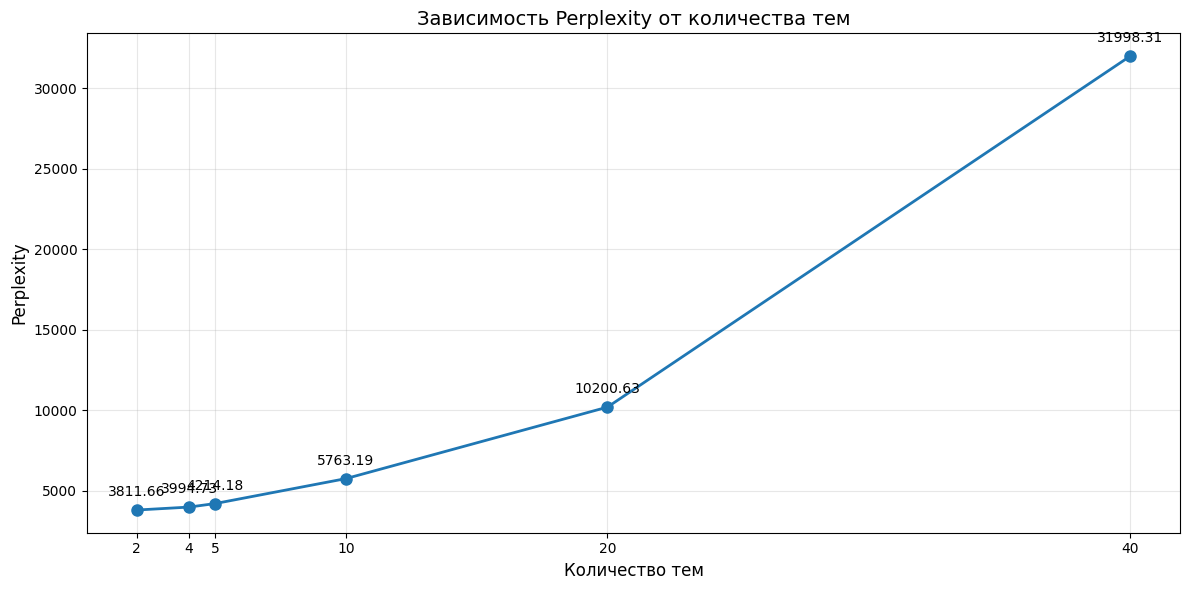


значения perplexity для каждого количества тем:
  2 тем: perplexity = 3811.6596
  4 тем: perplexity = 3994.7344
  5 тем: perplexity = 4214.1769
  10 тем: perplexity = 5763.1913
  20 тем: perplexity = 10200.6350
  40 тем: perplexity = 31998.3084


In [24]:
n_topics_values = list(perplexities.keys())
perplexity_values = list(perplexities.values())

plt.figure(figsize=(12, 6))
plt.plot(n_topics_values, perplexity_values, 'o-', linewidth=2, markersize=8)
plt.xlabel('Количество тем', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Зависимость Perplexity от количества тем', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(n_topics_values)

for i in range(len(n_topics_values)):
    plt.annotate(f'{perplexity_values[i]:.2f}', 
                (n_topics_values[i], perplexity_values[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.savefig(os.path.join(lab3_2_path, 'perplexity_vs_topics.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nзначения perplexity для каждого количества тем:")
for n_topics, perplexity in perplexities.items():
    print(f"  {n_topics} тем: perplexity = {perplexity:.4f}")

Подбор степени полинома
  Полином 2 степени: r2 = 0.9996
  Полином 3 степени: r2 = 0.9999
  Полином 4 степени: r2 = 1.0000

лучшая аппроксимация: Полином 4 степени с r2 = 1.0000


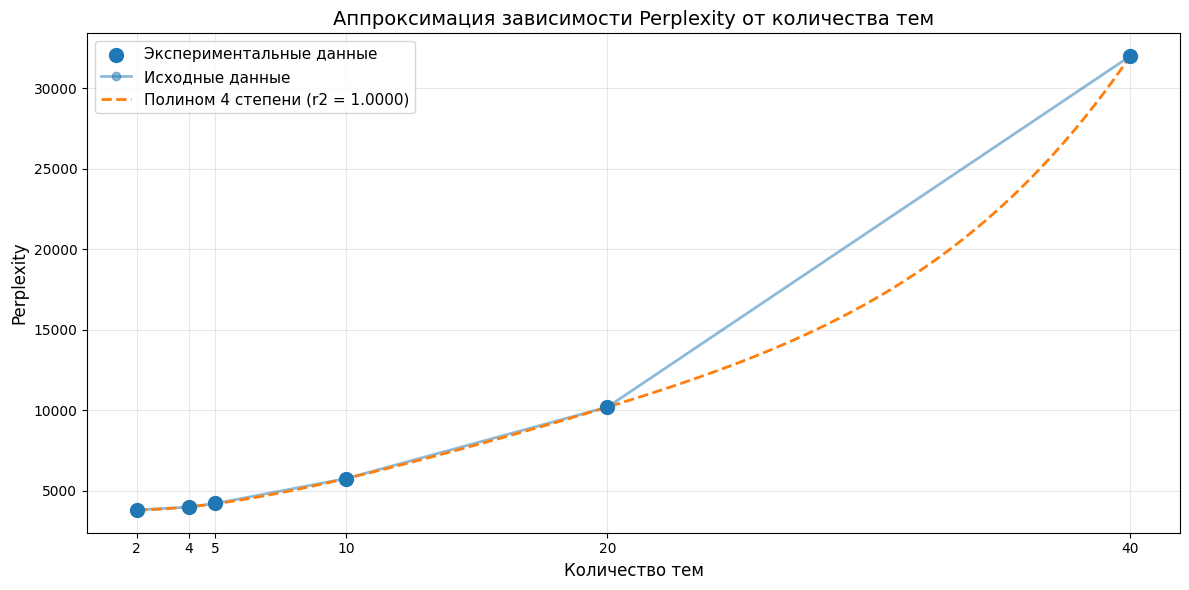

In [25]:
x = np.array(n_topics_values)
y = np.array(perplexity_values)

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def poly4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

functions = [poly2, poly3, poly4]
function_names = ['Полином 2 степени', 'Полином 3 степени', 'Полином 4 степени']

best_r2 = -float('inf')
best_func = None
best_params = None
best_name = None

print("Подбор степени полинома")
for func, name in zip(functions, function_names):
    try:
        popt, _ = curve_fit(func, x, y)
        y_pred = func(x, *popt)

        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        print(f"  {name}: r2 = {r2:.4f}")
        
        if r2 > best_r2:
            best_r2 = r2
            best_func = func
            best_params = popt
            best_name = name
    except:
        print(f"  {name}: не удалось подобрать параметры")

print(f"\nлучшая аппроксимация: {best_name} с r2 = {best_r2:.4f}")

# Строим график с аппроксимацией
plt.figure(figsize=(12, 6))
plt.scatter(x, y, s=100, label='Экспериментальные данные', zorder=3)
plt.plot(n_topics_values, perplexity_values, 'o-', linewidth=2, alpha=0.5, label='Исходные данные')

x_smooth = np.linspace(min(x), max(x), 300)
y_smooth = best_func(x_smooth, *best_params)
plt.plot(x_smooth, y_smooth, '--', linewidth=2, label=f'{best_name} (r2 = {best_r2:.4f})')

plt.xlabel('Количество тем', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Аппроксимация зависимости Perplexity от количества тем', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(n_topics_values)
plt.tight_layout()
plt.savefig(os.path.join(lab3_2_path, 'perplexity_approximation.png'), dpi=300, bbox_inches='tight')
plt.show()

In [29]:

optimal_n_topics = n_topics_values[perplexity_values.index(min(perplexity_values))]
min_perplexity = min(perplexity_values)

for n_topics in n_topics_values:
    print(f"Количество тем: {n_topics:2d} | Perplexity: {perplexities[n_topics]:.4f}{marker}")

print(f"оптимальное кол-во тем: {optimal_n_topics}")
print(f"Perplexity: {min_perplexity:.4f}")
print(f"лучшая аппроксимация: {best_name} с r2 = {best_r2:.4f}")

print(f"\nтоп 10 слов для оптимальной модели ({optimal_n_topics} тем):")
for i, words in enumerate(top_words_dict[optimal_n_topics]):
    print(f"  Тема {i+1}: {', '.join(words[:10])}")

optimal_doc_topic_probs = doc_topic_probs[optimal_n_topics]
#print({optimal_doc_topic_probs.shape})
#print(optimal_doc_topic_probs[0])

Количество тем:  2 | Perplexity: 3811.6596
Количество тем:  4 | Perplexity: 3994.7344
Количество тем:  5 | Perplexity: 4214.1769
Количество тем: 10 | Perplexity: 5763.1913
Количество тем: 20 | Perplexity: 10200.6350
Количество тем: 40 | Perplexity: 31998.3084
оптимальное кол-во тем: 2
Perplexity: 3811.6596
лучшая аппроксимация: Полином 4 степени с r2 = 1.0000

топ 10 слов для оптимальной модели (2 тем):
  Тема 1: oil, price, 39, reuters, new, u, say, stock, U.S., high
  Тема 2: 39, say, reuters, gt, lt, Inc., company, fullquote, stock, n


In [27]:
print(f"(оптимальная модель: {optimal_n_topics} тем)")
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_idx = np.argmax(doc_probs)
    top_prob = doc_probs[top_doc_idx]
    print(f"Тема {topic_idx+1}: документ #{top_doc_idx} (вероятность = {top_prob:.4f})")

print(f"топ 5 документов для каждой темы (с наибольшей вероятностью):")

top_k = 5
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_indices = np.argsort(doc_probs)[::-1][:top_k]
    print(f"\nТема {topic_idx+1}:")
    for i, doc_idx in enumerate(top_doc_indices):
        prob = doc_probs[doc_idx]
        print(f"  {i+1}. Документ #{doc_idx} (вероятность = {prob:.4f})")

(оптимальная модель: 2 тем)
Тема 1: документ #3682 (вероятность = 0.9875)
Тема 2: документ #3157 (вероятность = 0.9943)
топ 5 документов для каждой темы (с наибольшей вероятностью):

Тема 1:
  1. Документ #3682 (вероятность = 0.9875)
  2. Документ #327 (вероятность = 0.9865)
  3. Документ #475 (вероятность = 0.9852)
  4. Документ #528 (вероятность = 0.9852)
  5. Документ #2904 (вероятность = 0.9851)

Тема 2:
  1. Документ #3157 (вероятность = 0.9943)
  2. Документ #4850 (вероятность = 0.9941)
  3. Документ #4368 (вероятность = 0.9935)
  4. Документ #1260 (вероятность = 0.9929)
  5. Документ #6708 (вероятность = 0.9928)


Эксперименты с различным количеством итераций
Тестируемые количества итераций: [25, 50, 100]
Количество итераций: 25
  Тем:  2 | Perplexity: 3811.4795
  Тем:  4 | Perplexity: 4037.0771
  Тем:  5 | Perplexity: 4260.0597
  Тем: 10 | Perplexity: 5769.8127
  Тем: 20 | Perplexity: 10232.4187
  Тем: 40 | Perplexity: 31955.7341
Количество итераций: 50
  Тем:  2 | Perplexity: 3811.6596
  Тем:  4 | Perplexity: 3994.7344
  Тем:  5 | Perplexity: 4214.1769
  Тем: 10 | Perplexity: 5763.1913
  Тем: 20 | Perplexity: 10200.6350
  Тем: 40 | Perplexity: 31998.3084
Количество итераций: 100
  Тем:  2 | Perplexity: 3810.5561
  Тем:  4 | Perplexity: 3988.2459
  Тем:  5 | Perplexity: 4201.2292
  Тем: 10 | Perplexity: 5768.9305
  Тем: 20 | Perplexity: 10193.5516
  Тем: 40 | Perplexity: 32014.3737


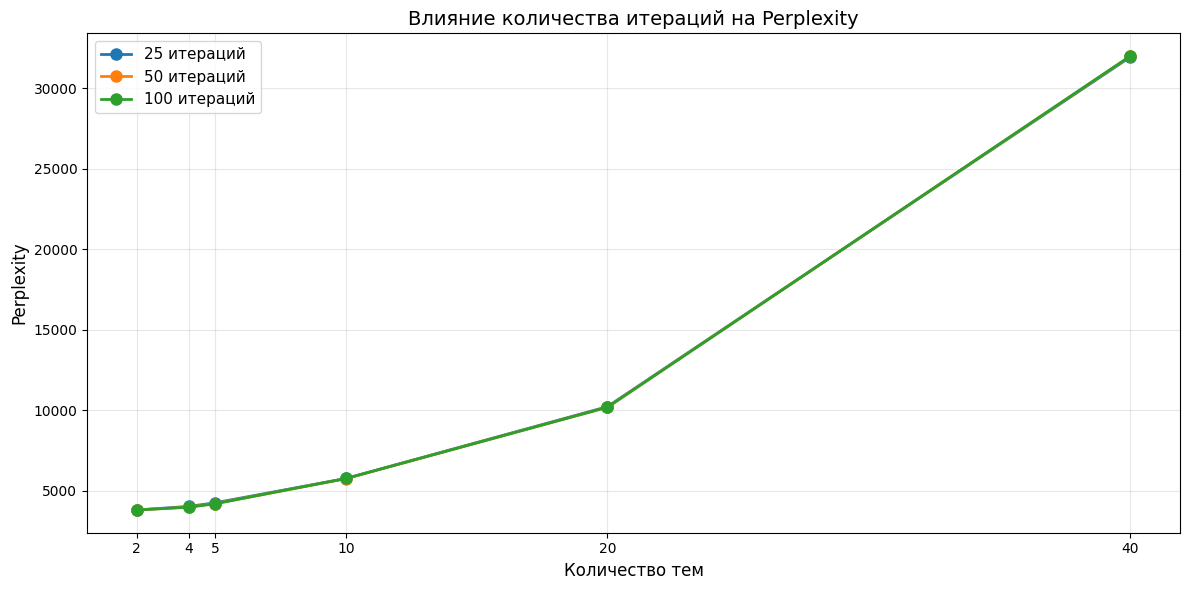

25 итераций: средний perplexity = 10011.0970
50 итераций: средний perplexity = 9997.1176
100 итераций: средний perplexity = 9996.1478

Оптимальное количество итераций: 100
Среднее значение perplexity: 9996.1478


In [28]:
print("Эксперименты с различным количеством итераций")

original_iterations = 50 
iteration_counts = [original_iterations // 2, original_iterations, original_iterations * 2]
print(f"Тестируемые количества итераций: {iteration_counts}")

iter_results = {}

for max_iter in iteration_counts:
    print(f"Количество итераций: {max_iter}")
    iter_perplexities = []
    
    for n_topics in n_topics_list:
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=max_iter,
            learning_method='batch',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        lda.fit(tdm_train)
        perplexity = lda.perplexity(tdm_test)
        iter_perplexities.append(perplexity)
        print(f"  Тем: {n_topics:2d} | Perplexity: {perplexity:.4f}")
    
    iter_results[max_iter] = iter_perplexities

plt.figure(figsize=(12, 6))
for max_iter in iteration_counts:
    plt.plot(n_topics_list, iter_results[max_iter], 'o-', 
            label=f'{max_iter} итераций', linewidth=2, markersize=8)

plt.xlabel('Количество тем', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Влияние количества итераций на Perplexity', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(n_topics_list)
plt.tight_layout()
plt.savefig(os.path.join(lab3_2_path, 'iterations_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


# Находим оптимальное количество итераций
avg_perplexities = {iter_count: np.mean(perplexities) 
                    for iter_count, perplexities in iter_results.items()}

for iter_count, avg_perp in avg_perplexities.items():
    print(f"{iter_count} итераций: средний perplexity = {avg_perp:.4f}")

optimal_iter = min(avg_perplexities, key=avg_perplexities.get)
print(f"\nОптимальное количество итераций: {optimal_iter}")
print(f"Среднее значение perplexity: {avg_perplexities[optimal_iter]:.4f}")